# Image generation with universal control using Flex.2 and OpenVINO

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>

Flex.2 is flexible text-to-image diffusion model based on Flux model architecture with built in support inpainting and universal control - model accepts pose, line, and depth inputs.

![examples.png](https://github.com/user-attachments/assets/6a9ab66a-387a-4538-8625-2bb3a16072b5)

More details about model can be found in [model card](https://huggingface.co/ostris/Flex.2-preview).

In this tutorial we consider how to convert and optimize Flex.2 model using OpenVINO.

>**Note**: Some demonstrated models can require at least 32GB RAM for conversion and running.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model with OpenVINO](#Convert-model-with-OpenVINO)
    - [Convert model using Optimum Intel](#Convert-model-using-Optimum-Intel)
    - [Compress model weights](#Compress-model-weights)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select inference device](#Select-inference-device)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/flex.2-image-generation/flex.2-image-generation.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform

%pip install -q "transformers>=4.51" "diffusers>=0.33.0" "gradio>=5.30" "torch>=2.2" "torchvision" "pillow" "sentencepiece" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q --pre -U "openvino>=2025.1.0" "nncf>=2.16.0" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

In [2]:
from pathlib import Path
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py")
    open("cmd_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flex2-image-generation/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("ov_flex2_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flex2-image-generation/ov_flex2_helper.py")
    open("ov_flex2_helper.py", "w").write(r.text)

if not Path("pipeline.py").exists():
    r = requests.get(url="https://huggingface.co/spaces/VIDraft/Flex-preview/resolve/main/pipeline.py")
    open("pipeline.py", "w").write(r.text)

## Convert model with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.
  
### Convert model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

### Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) integration to `optimum-cli` tool for weight compression.

In [3]:
import ipywidgets as widgets

model_id = "ostris/Flex.2-preview"
model_base_path = Path(model_id.split("/")[-1])

to_compress = widgets.Checkbox(
    value=True,
    description="Weight compression",
    disabled=False,
)

to_compress

Checkbox(value=True, description='Weight compression')

In [4]:
# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("flex.2-image-generation.ipynb")


model_path = model_base_path / "INT8" if to_compress.value else model_base_path / "FP16"

additional_args = {}

from cmd_helper import optimum_cli


if not model_path.exists():
    if to_compress.value:
        additional_args.update({"weight-format": "int8"})
    else:
        additional_args.update({"weight-format": "fp16"})

    optimum_cli(model_id, model_path, additional_args=additional_args)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

Flex.2 is based on Flux.1 model, but for enabling image control and inpainting capability, model uses own customized pipeline. `ov_flex2_helper.py` contains `OVFlex2Pipeline` class, pipeline adoption for usage with OpenVINO. It is based on Optimum Intel inference API and preserves functional features from original pipeline.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [5]:
from notebook_utils import device_widget

device = device_widget(exclude=["NPU"])

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
from ov_flex2_helper import OVFlex2Pipeline

ov_pipe = OVFlex2Pipeline.from_pretrained(model_path, device=device.value)

Let's check model inference result. In this example, we will provide input image, inpainting mask and depth map as pipeline inputs for turning dog to robot. In similar way, you also can provide estimated pose or lines for controlling image generation as well as use image conditioning and inpainting as separated features (if you do not provide control image or inpainting mask respectively).

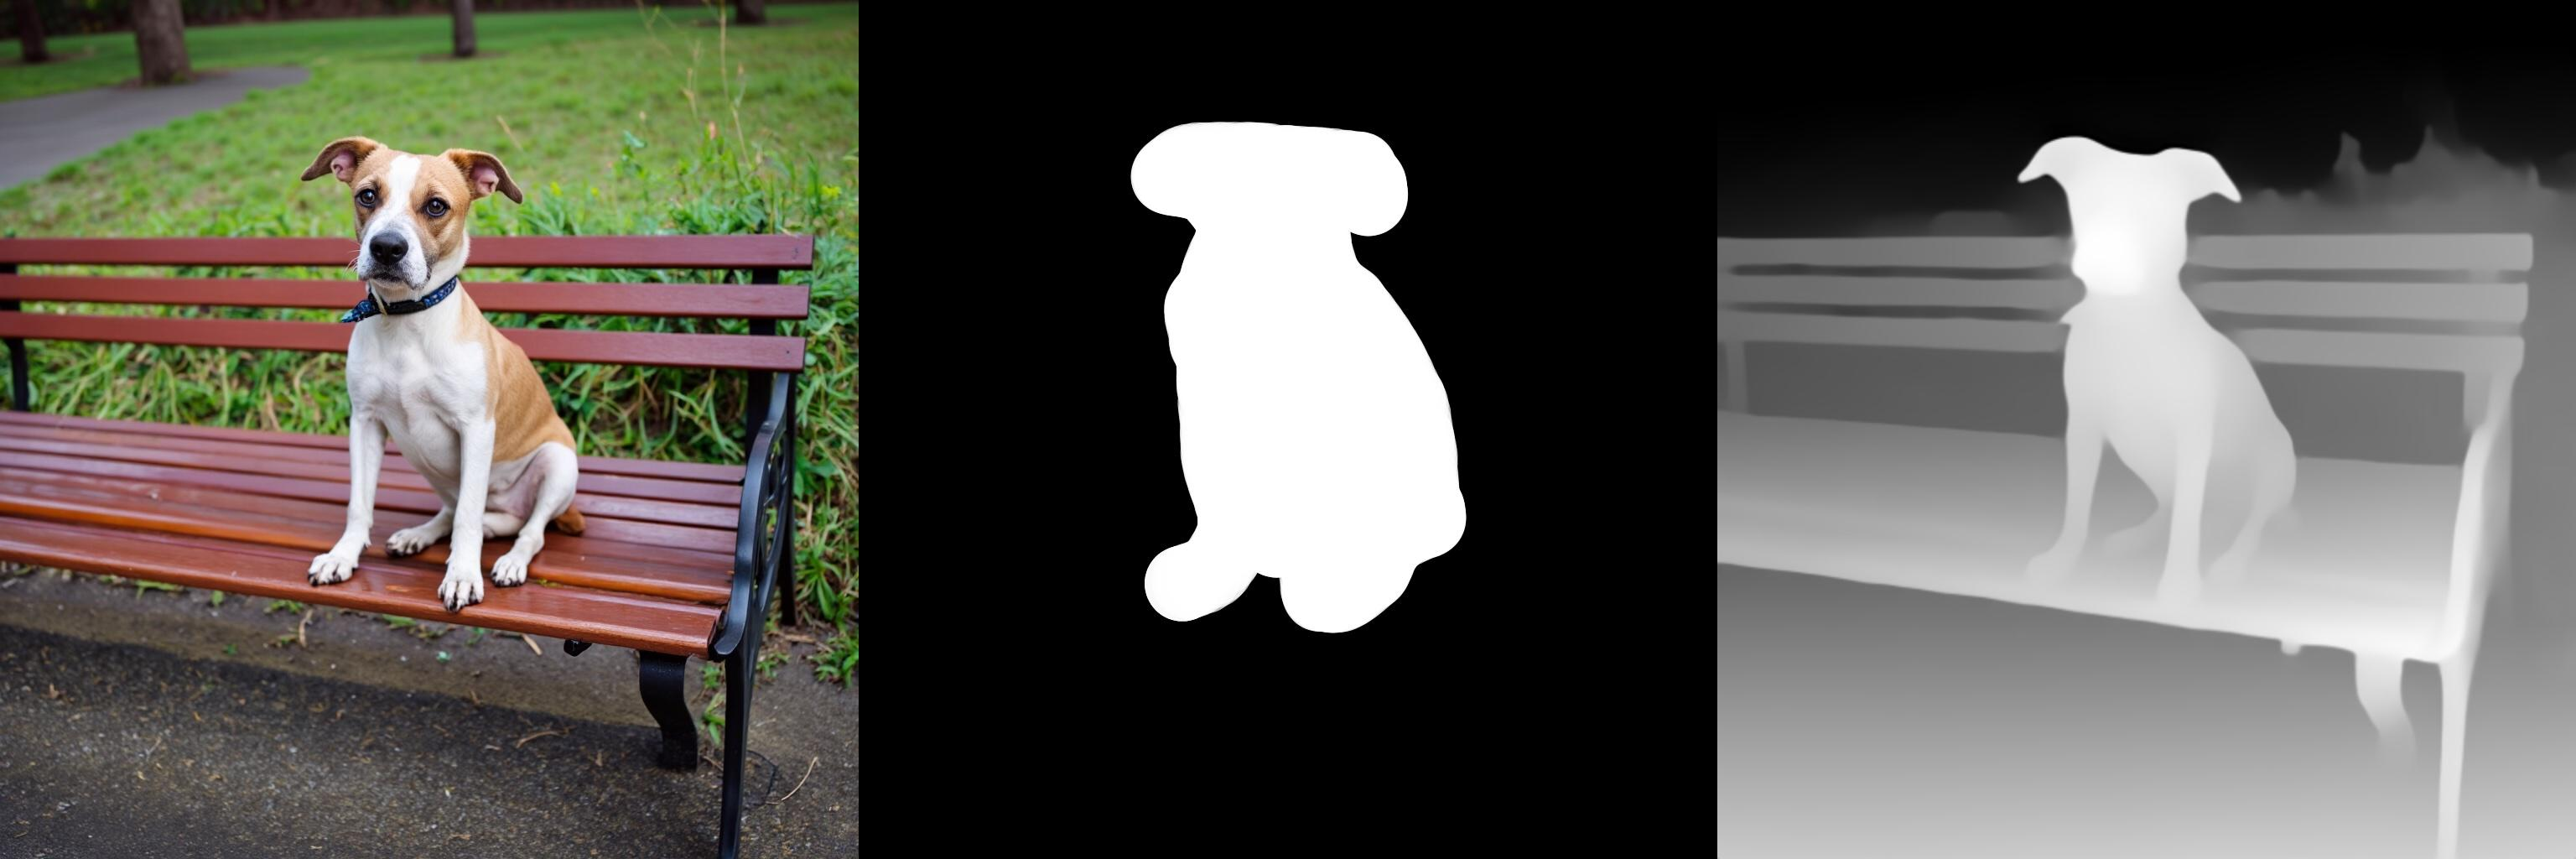

In [7]:
from diffusers.utils import load_image, make_image_grid

image_path = Path("dog.jpg")
inpaint_path = Path("dog_mask.jpg")
depth_path = Path("dog_depth.jpg")

if not image_path.exists():
    inpaint_image = load_image("https://ostris.com/wp-content/uploads/2025/04/dog.jpg")
    inpaint_image.save(image_path)
else:
    inpaint_image = load_image(str(image_path))

if not inpaint_path.exists():
    inpaint_mask = load_image("https://ostris.com/wp-content/uploads/2025/04/dog_mask.jpg")
    inpaint_mask.save(inpaint_path)
else:
    inpaint_mask = load_image(str(inpaint_path))

if not depth_path.exists():
    control_image = load_image("https://ostris.com/wp-content/uploads/2025/04/dog_depth.jpg")
    control_image.save(depth_path)
else:
    control_image = load_image(str(depth_path))

make_image_grid([inpaint_image, inpaint_mask, control_image], rows=1, cols=3)

inpaint_image.shape (1024, 1024)
inpaint_mask.shape (1024, 1024)
latent_controls.shape torch.Size([1, 33, 64, 64])
num_control_channels.shape 33
height_latent_controls 64
width_latent_controls 64


  0%|          | 0/20 [00:00<?, ?it/s]

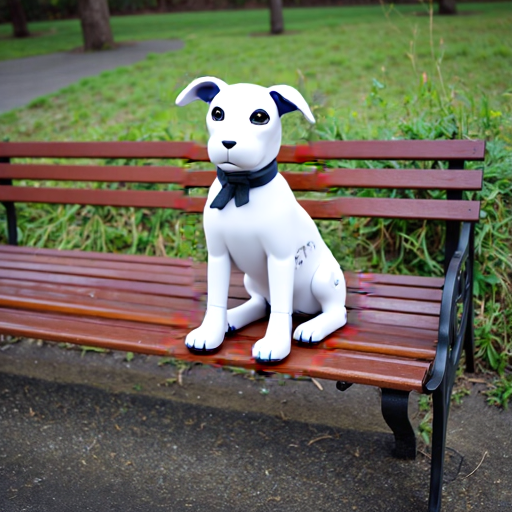

In [8]:
import torch

image = ov_pipe(
    prompt="A white friendly robotic dog sitting on a bench",
    inpaint_image=inpaint_image,
    inpaint_mask=inpaint_mask,
    control_image=control_image,
    control_strength=0.5,
    control_stop=0.33,
    height=512,
    width=512,
    guidance_scale=3.5,
    num_inference_steps=20,
    generator=torch.Generator("cpu").manual_seed(42),
).images[0]

image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_pipe)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)